# GMM on Original Data

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from GMM import GMM
from covariance_types import CovarianceType
import seaborn as sns
import sys
import os

sys.path.append(os.path.abspath(".."))
from external_metrics import *
from internal_metrics import *


load data

In [2]:
X = pd.read_csv("../data_processed.csv").to_numpy()
Y = pd.read_csv("../data.csv")["diagnosis"].to_numpy()

In [3]:
X,Y

(array([[ 1.09609953, -2.0715123 ,  1.26881726, ...,  2.2940576 ,
          2.74820411,  1.93531174],
        [ 1.82821197, -0.35332152,  1.68447255, ...,  1.08612862,
         -0.24367526,  0.28094279],
        [ 1.5784992 ,  0.45578591,  1.56512598, ...,  1.95328166,
          1.15124203,  0.20121416],
        ...,
        [ 0.70166686,  2.04377549,  0.67208442, ...,  0.41370467,
         -1.10357792, -0.31812924],
        [ 1.83672491,  2.33440316,  1.98078127, ...,  2.28797231,
          1.9173959 ,  2.21768395],
        [-1.80681144,  1.22071793, -1.81279344, ..., -1.7435287 ,
         -0.04809589, -0.75054629]], shape=(569, 30)),
 array(['M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M',
        'M', 'M', 'M', 'M', 'M', 'M', 'B', 'B', 'B', 'M', 'M', 'M', 'M',
        'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'B', 'M',
        'M', 'M', 'M', 'M', 'M', 'M', 'M', 'B', 'M', 'B', 'B', 'B', 'B',
        'B', 'M', 'M', 'B', 'M', 'M', 'B', 'B', 'B', 'B', 'M', '

Initialize covariance types and number of clusters

In [4]:
covariance_types = [CovarianceType.FULL, CovarianceType.TIED,
                    CovarianceType.DIAG, CovarianceType.SPHERICAL]
k_vals = range(1, 10)

## 1. Internal Validation Metrics

Append all evaluation metrics initially in a loop

In [5]:
results = []

for cov_type in covariance_types:
    for k in k_vals:
        # Fit GMM
        gmm_instance = GMM(k=k, covariance_type=cov_type, conv_limit=1e-6, max_iter=100, seed=42)
        gmm_instance.fit(X)
        
        # Cluster assignments
        r = gmm_instance.r
        clusters = np.argmax(r, axis=1)
        
        # Compute metrics
        bic_score = gmm_instance.bic(X)
        aic_score = gmm_instance.aic(X)
        sil_score = silhouette_score(X, clusters)
        db_score = davies_bouldin(X, clusters)
        ch_score = calinski_harabasz(X, clusters)
        wcss_score = wcss(X,clusters)
        ll = gmm_instance.compute_log_likelihood(X)
        
        # External metrics
        ari = adjusted_rand_index(Y, clusters)
        nmi = normalized_mutual_info(Y, clusters)
        purity = purity_score(Y, clusters)
        
        # Binary classification metrics
        binary_metrics = compute_binary_metrics(Y, clusters, positive_class='M')
        
        # Store results
        results.append({
            "Number of components": k,
            "cov_type": cov_type,
            "BIC": bic_score,
            "AIC": aic_score,
            "Silhouette": sil_score,
            "Davies-Bouldin": db_score,
            "Calinski-Harabasz": ch_score,
            "WCSS": wcss_score,
            "Log-Likelihood": ll,
            "ARI": ari,
            "NMI": nmi,
            "Purity": purity,
            "Accuracy": binary_metrics['accuracy']
        })

df_metrics = pd.DataFrame(results)

Get the best model

In [6]:
best_bic_row = df_metrics.loc[df_metrics['BIC'].idxmin()]
best_k = best_bic_row['Number of components']
best_cov = best_bic_row['cov_type']
# Fit best model
best_gmm = GMM(
    k=int(best_k),
    covariance_type=best_cov,
    conv_limit=1e-4,
    max_iter=100
)
best_gmm.fit(X)

# Hard cluster assignments from the new model
clusters = np.argmax(best_gmm.r, axis=1)

# Map clusters to true classes for interpretability
mapped_clusters = map_clusters_to_labels(clusters, assign_clusters_to_classes(Y, clusters))


Plot the best model

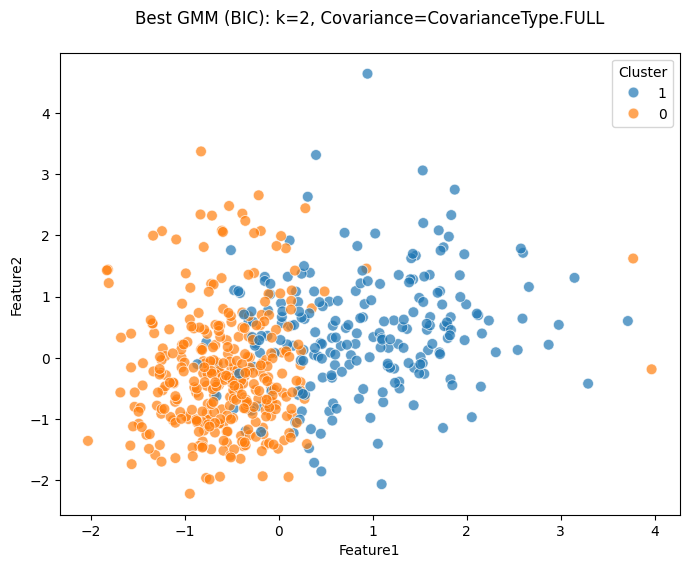

In [7]:
df_clusters = pd.DataFrame({
    'Feature1': X[:,0],
    'Feature2': X[:,1],
    'Cluster': clusters.astype(str)
})

plt.figure(figsize=(8,6))
sns.scatterplot(
    data=df_clusters,
    x='Feature1',
    y='Feature2',
    hue='Cluster',
    palette='tab10',
    s=60,
    alpha=0.7
)
plt.title(f"Best GMM (BIC): k={best_k}, Covariance={best_cov}\n")
plt.show()


Plot each metric

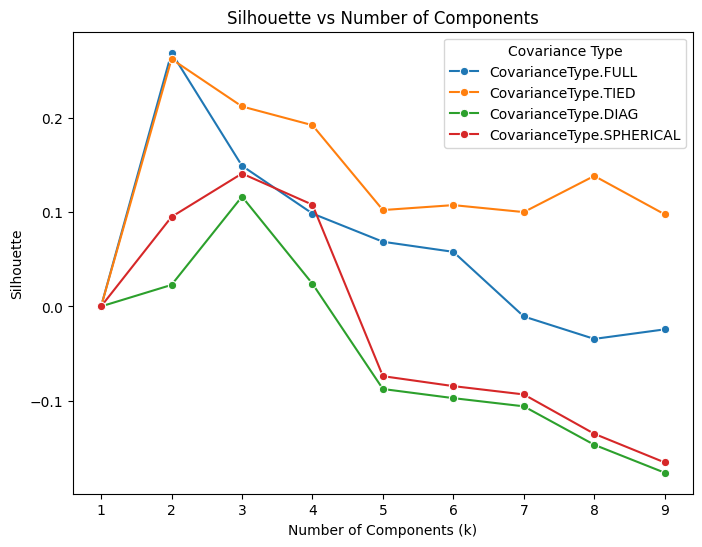

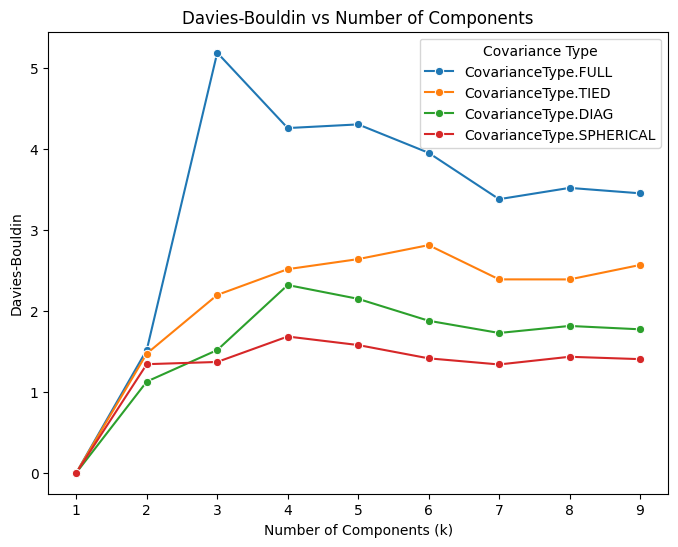

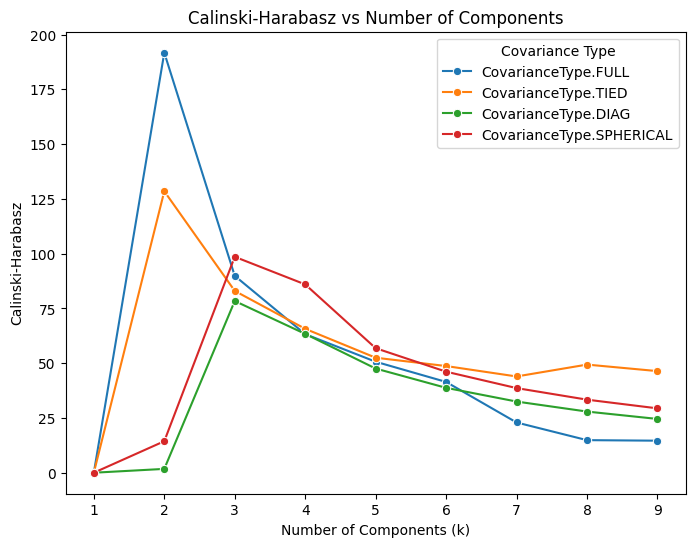

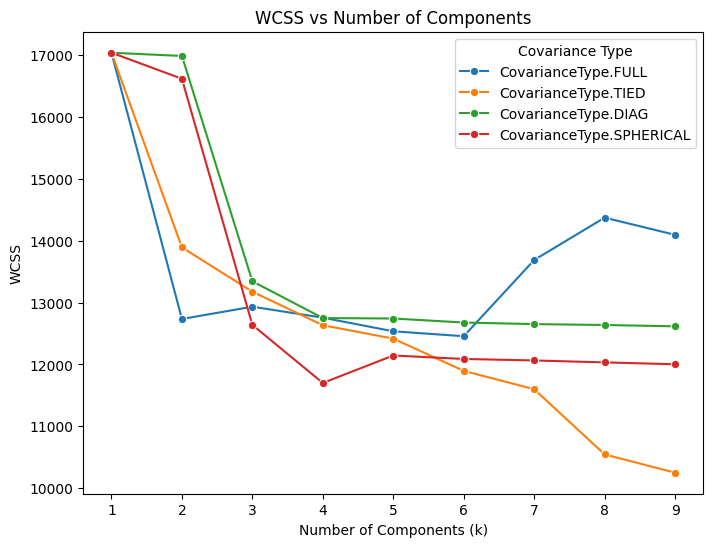

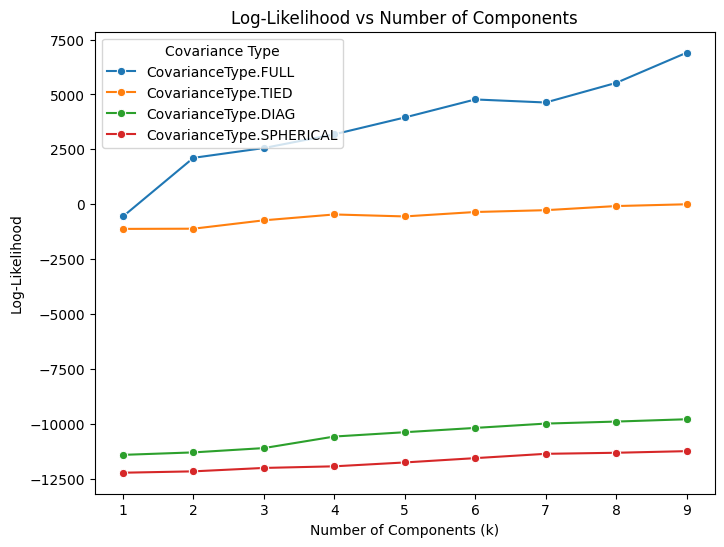

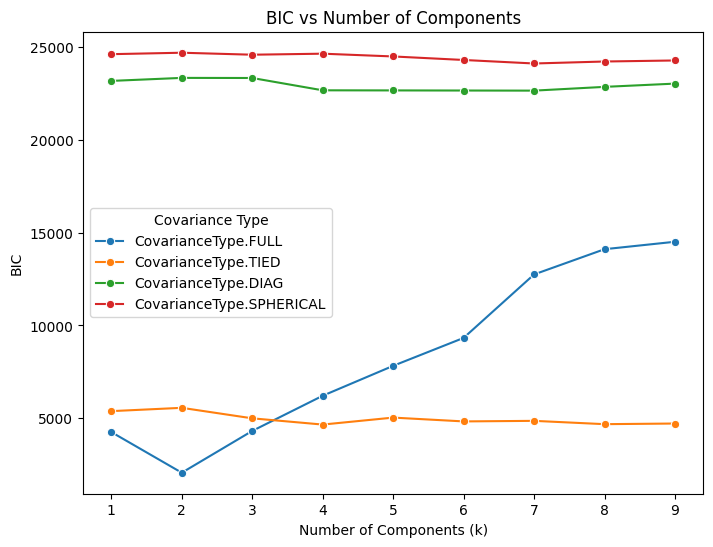

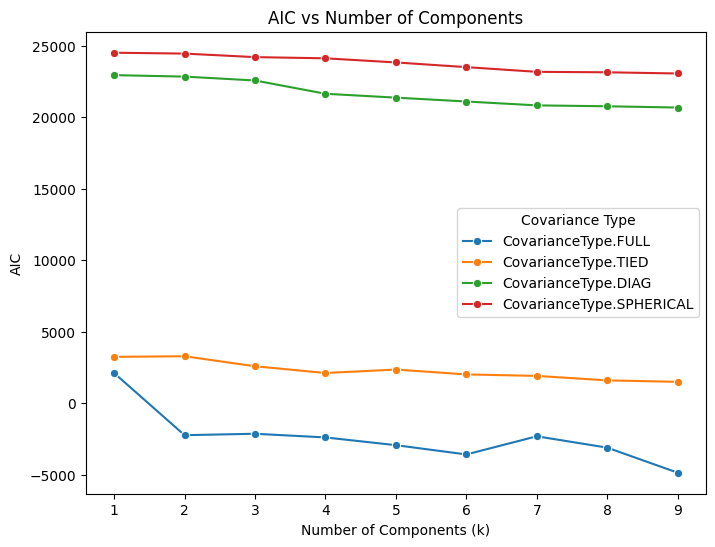

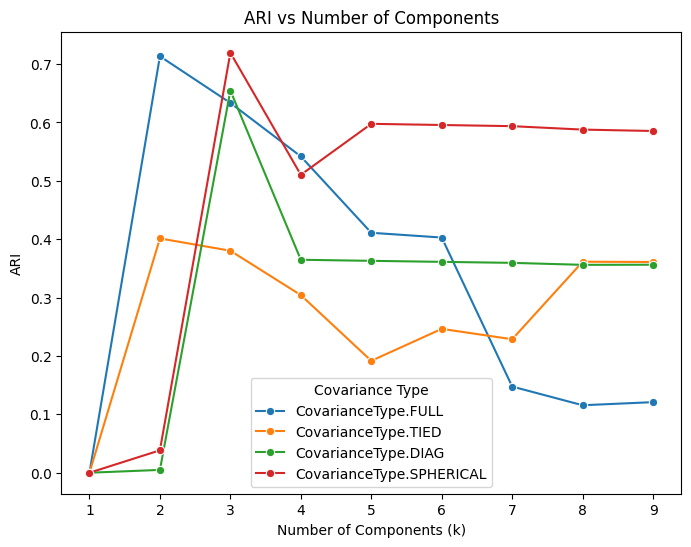

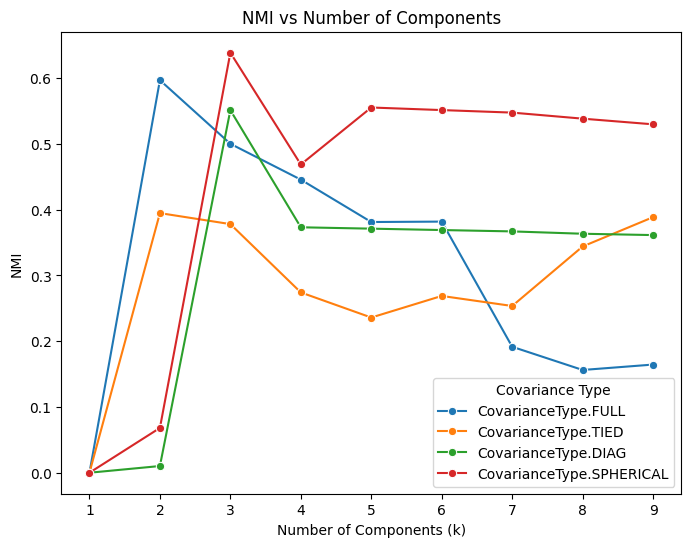

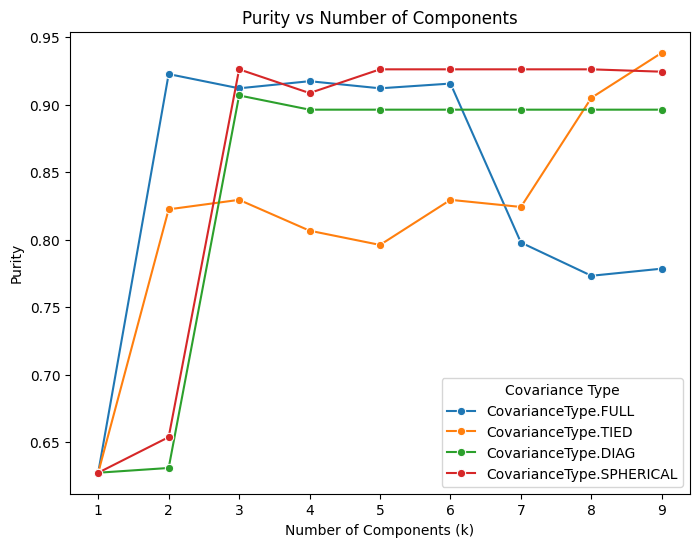

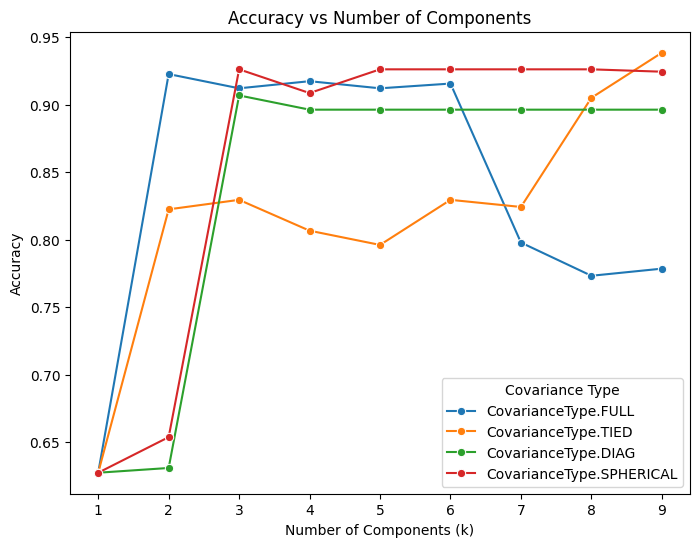

In [8]:
df_internal = df_metrics.melt(
    id_vars=["Number of components", "cov_type"],
    value_vars=["Silhouette", "Davies-Bouldin", "Calinski-Harabasz","WCSS","Log-Likelihood","BIC","AIC","ARI","NMI","Purity","Accuracy"],
    var_name="Metric",
    value_name="Score"
)
metrics_to_plot = ["Silhouette", "Davies-Bouldin", "Calinski-Harabasz","WCSS","Log-Likelihood","BIC","AIC","ARI","NMI","Purity","Accuracy"]

for metric in metrics_to_plot:
    plt.figure(figsize=(8,6))
    sns.lineplot(
        data=df_internal[df_internal["Metric"] == metric],
        x="Number of components",
        y="Score",
        hue="cov_type",
        marker="o"
    )
    plt.title(f"{metric} vs Number of Components")
    plt.xlabel("Number of Components (k)")
    plt.ylabel(metric)
    plt.legend(title="Covariance Type")
    plt.show()

## 2. External Validation Metrics

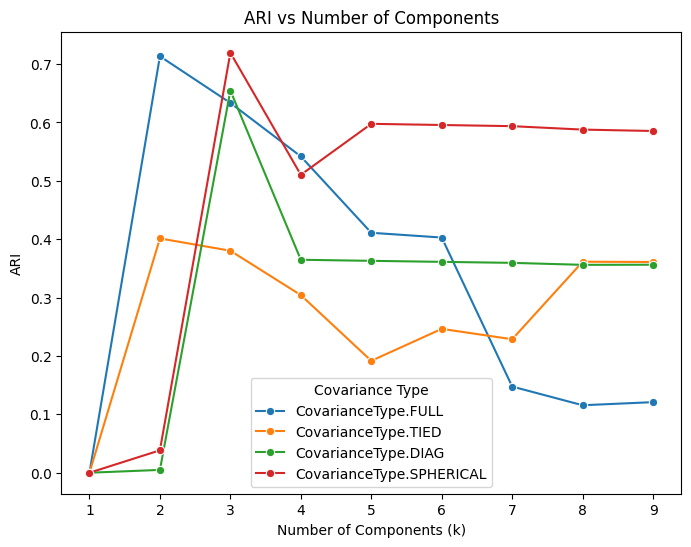

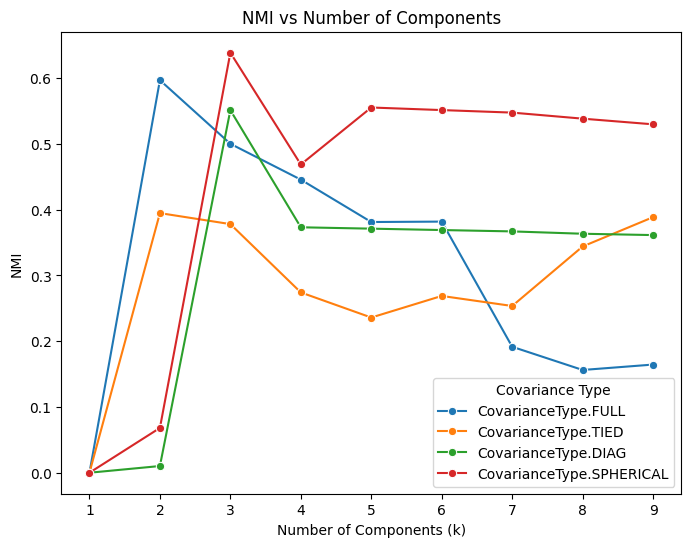

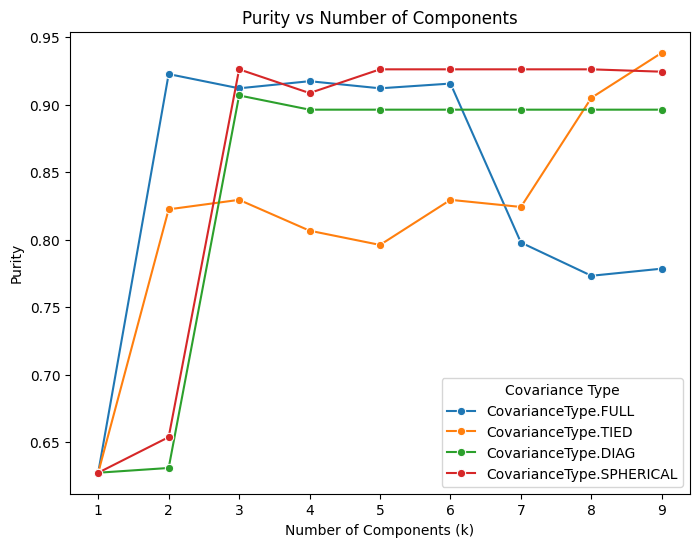

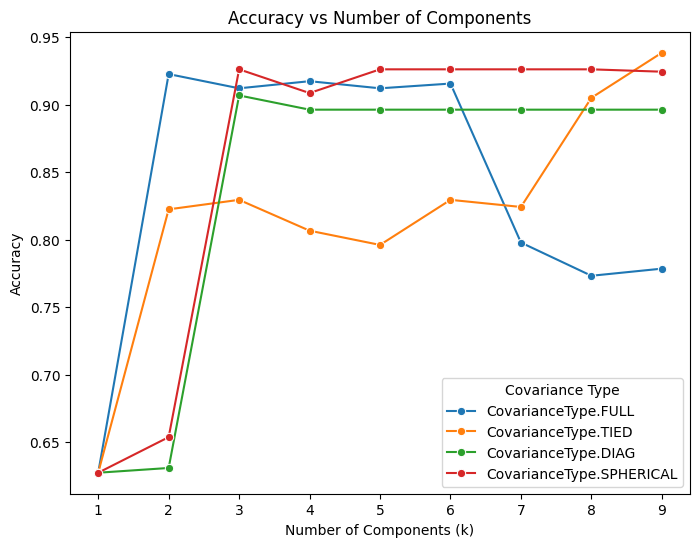

In [9]:
df_internal = df_metrics.melt(
    id_vars=["Number of components", "cov_type"],
    value_vars=["ARI","NMI","Purity","Accuracy"],
    var_name="Metric",
    value_name="Score"
)
metrics_to_plot = ["ARI","NMI","Purity","Accuracy"]

for metric in metrics_to_plot:
    plt.figure(figsize=(8,6))
    sns.lineplot(
        data=df_internal[df_internal["Metric"] == metric],
        x="Number of components",
        y="Score",
        hue="cov_type",
        marker="o"
    )
    plt.title(f"{metric} vs Number of Components")
    plt.xlabel("Number of Components (k)")
    plt.ylabel(metric)
    plt.legend(title="Covariance Type")
    plt.show()

Confusion Matrix for the best model

In [10]:
# confusion matrix: true labels vs clusters
cm = confusion_matrix(Y, mapped_clusters)


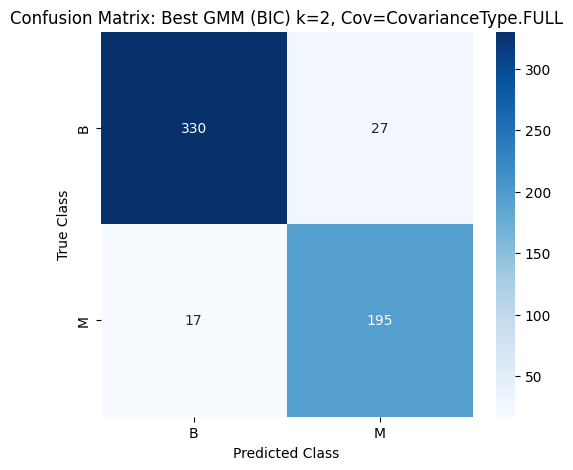

In [11]:
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(mapped_clusters),
            yticklabels=np.unique(Y))
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.title(f"Confusion Matrix: Best GMM (BIC) k={best_k}, Cov={best_cov}")
plt.show()

Since most of the features are correlated: by minimizing the covariance, the accuracy decreases. Therefore, the optimum scores are found at the full covariance and the worst scores are found at the spherical covariance where all correlation is diminshed.

Since the dataset is binary, according to our knowledge, the optimum number of Gaussians is 2. As the number of Gaussians increases, the more it leads to overfitting 

**Time complexity:** O(N x T x K x D^3)

**Space complexity:** O(Nd + NK + Kd²) for full covariance, O(Nd + NK + Kd) for diagonal covariance